In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import rice
from platipy.imaging.registration.utils import apply_transform
from platipy.imaging import ImageVisualiser
from platipy.imaging.label.utils import get_com
from shrimpy.augmentation import random_augmentation_transform,  generate_random_vector_field_transform
from shrimpy.augmentation import random_rotation_transform, random_translation_transform, random_scale_transform
from shrimpy.augmentation import consistent_vector_field_transform
from shrimpy.pipeline import read_augment_write, read_augment_write_directory
from shrimpy.intensity import randomly_augment_image_intensity, apply_noise
from shrimpy.image_generation import visualise_image, compare_image_histograms, create_augmentation_visualisaitons
from shrimpy.image_generation import collate_augmentation_visualisations, create_image_visualisations
%matplotlib inline

In [2]:
test_T1 = sitk.ReadImage("test_augs/ACRIN-6698-118307_AUG-0006/IMG_T1.nii.gz", sitk.sitkFloat64)
test_T2 = sitk.ReadImage("test_augs/ACRIN-6698-118307_AUG-0006/IMG_T2.nii.gz", sitk.sitkFloat64)
test_contour = sitk.ReadImage("test_augs/ACRIN-6698-118307_AUG-0006/MASK_TUMOUR.nii.gz")

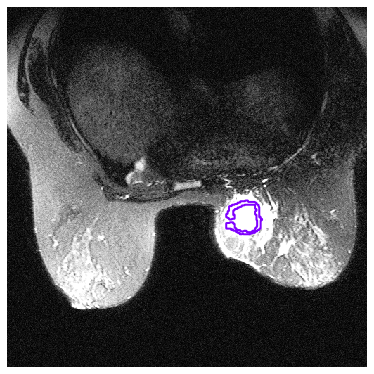

In [4]:
fig = visualise_image(test_T2, None, test_contour)

In [2]:
original_T1 = sitk.ReadImage("CONVERTED_PROCESSED/ACRIN-6698-102212/IMG_T1.nii.gz", sitk.sitkFloat64)
original_T2 = sitk.ReadImage("CONVERTED_PROCESSED/ACRIN-6698-102212/IMG_T2.nii.gz", sitk.sitkFloat64)
original_contour = sitk.ReadImage("CONVERTED_PROCESSED/ACRIN-6698-102212/MASK_TUMOUR.nii.gz")
image_directory = Path("images")
image_directory.mkdir(parents=True, exist_ok=True)

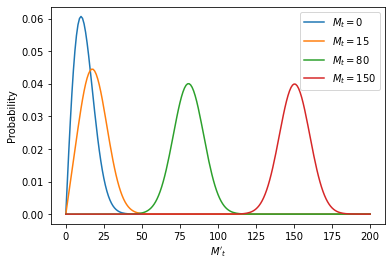

In [38]:
x = np.linspace(0, 200, 201)
y = rice.pdf(x, 0/10, scale=10)
plt.plot(x, y, label=r"$M_t = 0$")
y = rice.pdf(x, 15/10, scale=10)
plt.plot(x, y, label=r"$M_t = 15$")
y = rice.pdf(x, 80/10, scale=10)
plt.plot(x, y, label=r"$M_t = 80$")
y = rice.pdf(x, 150/10, scale=10)
plt.plot(x, y, label=r"$M_t = 150$")
plt.xlabel(r"$M'_t$")
plt.ylabel("Probability")
plt.legend()
plt.savefig(image_directory/"rice_distribution")
plt.show()


# plt.title("M = 150")
# plt.xlabel("M'")
# plt.savefig(image_directory/"rice_distribution_150")
# plt.show()

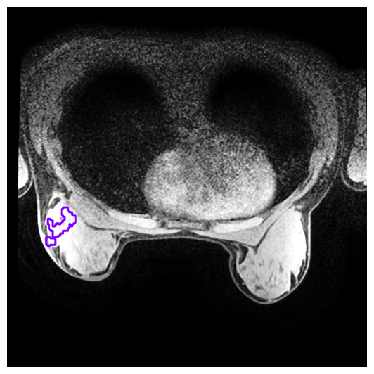

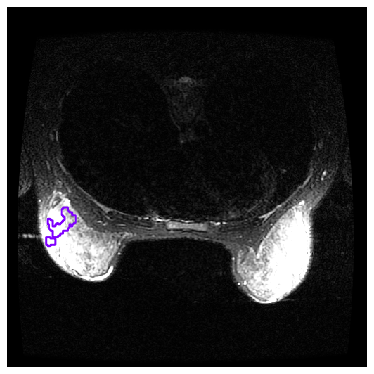

In [30]:
# vis = ImageVisualiser(original_T1, cut=get_com(original_contour), axis='z', figure_size_in=5)
# vis.add_contour(original_contour)
# fig = vis.show()
# fig.savefig(image_directory/"original_T1")
fig = visualise_image(original_T1, None, original_contour, image_directory/"original_T1")
fig = visualise_image(original_T2, None, original_contour, image_directory/"original_T2")

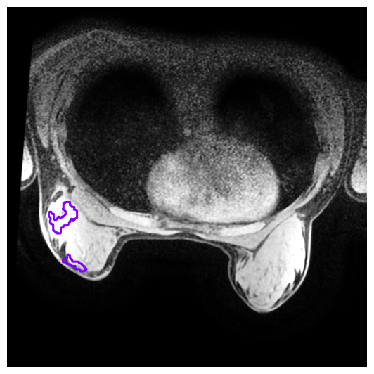

In [26]:
np.random.seed(0)
rotation_transform = random_rotation_transform(0.03)
fig = visualise_image(original_T1, rotation_transform, contour=original_contour, save_name=image_directory/"rotated_T1")

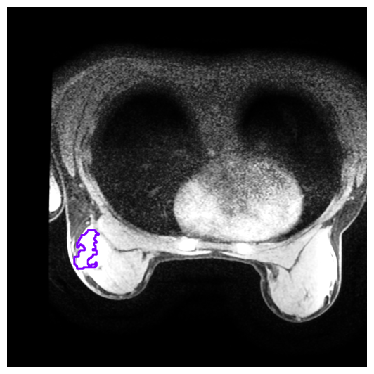

In [5]:
translation_transform = random_translation_transform(100)
fig = visualise_image(original_T1, translation_transform, original_contour, image_directory/"translated_T1")

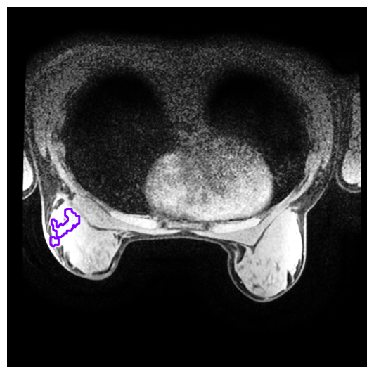

In [6]:
scale_transform = random_scale_transform(1.2)
fig = visualise_image(original_T1, scale_transform, original_contour, image_directory/"scaled_T1")

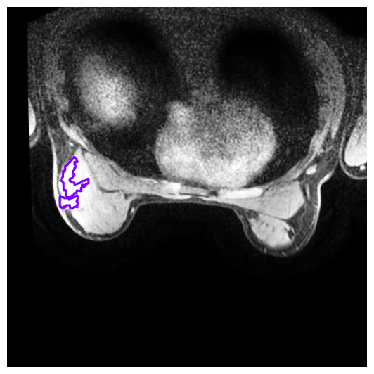

In [7]:
similarity_transform = random_augmentation_transform(1.2, 0.1, 50)
fig = visualise_image(original_T1, similarity_transform, original_contour, image_directory/"similar_T1")

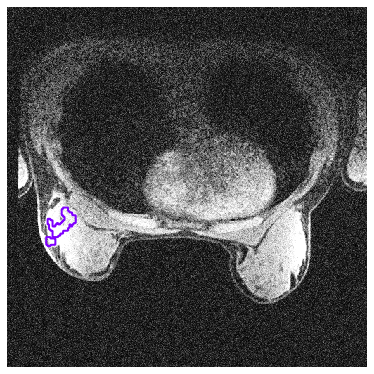

In [4]:
noisy_T1 = apply_noise(original_T1, sigma=50)
fig = visualise_image(noisy_T1, None, original_contour, image_directory/"noisy_T1")

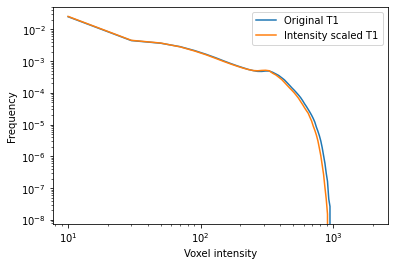

In [9]:
intensity_scaled_T1 = randomly_augment_image_intensity(original_T1, 2)
fig = compare_image_histograms(original_T1, intensity_scaled_T1, ["Original T1", "Intensity scaled T1"], image_directory/"intensity_scaled_histogram_T1")

In [10]:
print(get_com(original_contour))

[16, 314, 72]


In [8]:
help(ImageVisualiser.add_vector_overlay)

Help on function add_vector_overlay in module platipy.imaging.visualisation.visualiser:

add_vector_overlay(self, vector_image, min_value=False, max_value=False, colormap=<matplotlib.colors.LinearSegmentedColormap object at 0x0000026F717FB970>, alpha=0.75, arrow_scale=0.25, arrow_width=1, subsample=4, color_function='perpendicular', show_colorbar=True, name=None)
    Overlay a vector field on to the existing image
    
    Args:
        vector_image sitk.Image|dict): Vector image (will be displayed as ).
        name (str, optional): Name to give the vector field (only used if passing
                              sitk.Image as vector field). Defaults to None.
        colormap (matplotlib.colors.Colormap, optional): The colormap to be used when
                                                         overlaying this vector field. Defaults
                                                         to plt.cm.get_cmap("Spectral").
        alpha (float, optional): Alpha to apply to overlay v

generating peaks:


  0%|          | 0/1 [00:00<?, ?it/s]

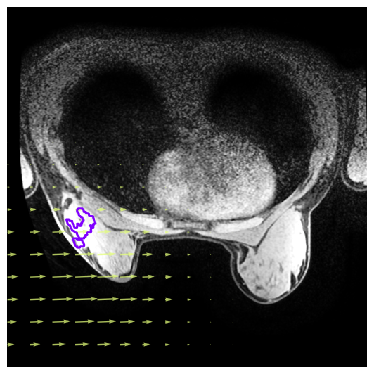

In [24]:
peak_voxels = np.array([[16, 400, 100]])
peak_vectors_mm = np.array([[0, 1, -20]])
one_peak_transform = consistent_vector_field_transform(original_T1, peak_vectors_mm, peak_voxels, 50)
# one_peak_transform = generate_random_vector_field_transform(original_T1, 100, 1, 10)
fig = visualise_image(original_T1, one_peak_transform, original_contour, image_directory/"one_peak_T1", one_peak_transform.GetDisplacementField())


generating and caching new kernel
generating peaks:


  0%|          | 0/1 [00:00<?, ?it/s]

[-33.0305542 -16.5152771   0.       ]


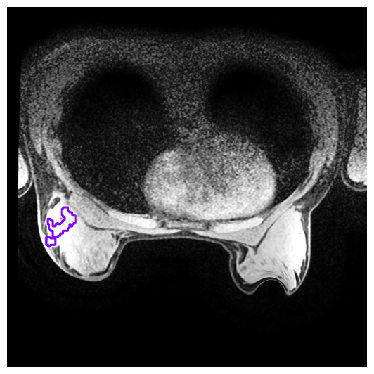

In [12]:
narrow_one_peak_transform = consistent_vector_field_transform(original_T1, peak_vectors_mm, peak_voxels, 10)
fig = visualise_image(original_T1, narrow_one_peak_transform, original_contour, image_directory/"one_peak_narrow_T1")

generating and caching new kernel
generating peaks:


  0%|          | 0/1 [00:00<?, ?it/s]

[-165.15277099  -82.5763855     0.        ]


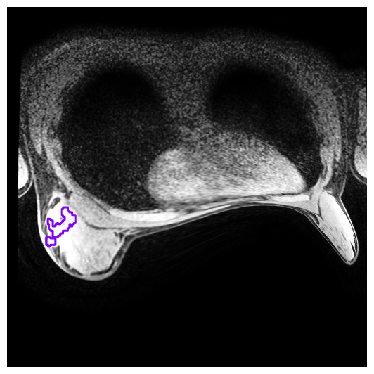

In [13]:
long_one_peak_transform = consistent_vector_field_transform(original_T1, peak_vectors_mm*5, peak_voxels, 50)
fig = visualise_image(original_T1, long_one_peak_transform, original_contour, image_directory/"one_peak_long_T1")

generating peaks:


  0%|          | 0/10 [00:00<?, ?it/s]

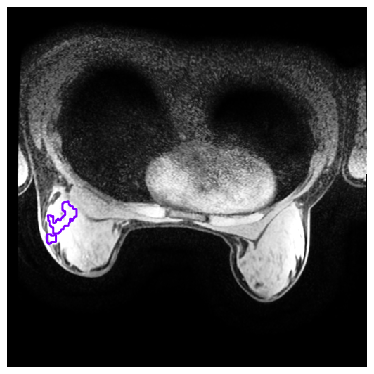

In [14]:
ten_peak_transform = generate_random_vector_field_transform(original_T1, 10, 10, 50)
fig = visualise_image(original_T1, ten_peak_transform, original_contour, image_directory/"ten_peak_T1")

generating peaks:


  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\arnal\anaconda3\lib\site-packages\platipy\imaging\visualisation\visualiser.py:1016: UserWarning: The following kwargs were not used by contour: 'label'
  temp = ax.contour(


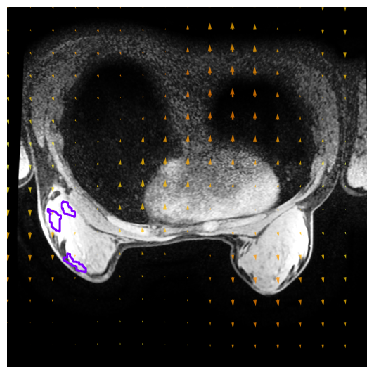

In [44]:
displacement_field_transform = generate_random_vector_field_transform(original_T1, 2, 1000, 50)
fig = visualise_image(original_T1, displacement_field_transform, original_contour, image_directory/"displacement_field_T1", displacement_field_transform.GetDisplacementField())

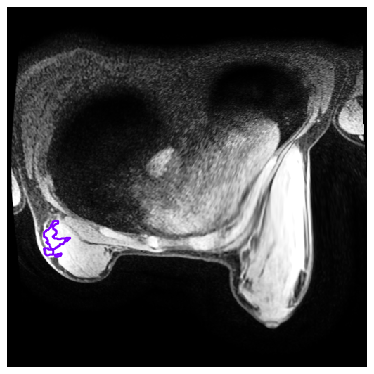

In [16]:
exagerated_displacement_field_array = sitk.GetArrayFromImage(displacement_field_transform.GetDisplacementField())*2
exagerated_displacement_field = sitk.GetImageFromArray(exagerated_displacement_field_array, isVector=True)
exagerated_displacement_field.CopyInformation(original_T1)
exagerated_displacement_field_transform = sitk.DisplacementFieldTransform(exagerated_displacement_field)
fig = visualise_image(original_T1, exagerated_displacement_field_transform, original_contour, image_directory/"exagerated_displacement_field_T1")

In [17]:
# A testament to my folly

# vis = ImageVisualiser(original_T1, cut=get_com(original_contour)[0], axis='z', figure_size_in=5)
# doot = vis.add_contour(original_contour)
# fig = vis.show()
# print(fig.get_axes())
# ax = fig.get_axes()[0]
# image = ax.get_images()[0]
# lines = ax.get_lines()
# print(ax.get_children())

# # help(ax.get_images()[0])
# print(ax.get_images()[0].get_array())
# fig2, ax2 = plt.subplots()
# ax2.imshow(image.get_array(), cmap=image.get_cmap())
# fig2.show()


In [27]:
create_augmentation_visualisaitons("AUGMENTATIONS_TEST", image_directory/"fully_augmented_images")

ACRIN-6698-102212_AUG-0000
ACRIN-6698-102212_AUG-0001
ACRIN-6698-102212_AUG-0002
ACRIN-6698-102212_AUG-0003
ACRIN-6698-102212_AUG-0004
ACRIN-6698-103939_AUG-0000
ACRIN-6698-103939_AUG-0001
ACRIN-6698-103939_AUG-0002
ACRIN-6698-103939_AUG-0003
ACRIN-6698-103939_AUG-0004
ACRIN-6698-104268_AUG-0000
ACRIN-6698-104268_AUG-0001
ACRIN-6698-104268_AUG-0002
ACRIN-6698-104268_AUG-0003
ACRIN-6698-104268_AUG-0004
ACRIN-6698-107700_AUG-0000
ACRIN-6698-107700_AUG-0001
ACRIN-6698-107700_AUG-0002
ACRIN-6698-107700_AUG-0003
ACRIN-6698-107700_AUG-0004
ACRIN-6698-116603_AUG-0000
ACRIN-6698-116603_AUG-0001
ACRIN-6698-116603_AUG-0002
ACRIN-6698-116603_AUG-0003
ACRIN-6698-116603_AUG-0004


In [41]:
create_image_visualisations("CONVERTED_PROCESSED", image_directory/"original_images")

C:\Users\arnal\anaconda3\lib\site-packages\platipy\imaging\visualisation\visualiser.py:1016: UserWarning: The following kwargs were not used by contour: 'label'
  temp = ax.contour(


ACRIN-6698-102212
ACRIN-6698-103939
ACRIN-6698-104268
ACRIN-6698-107700
ACRIN-6698-116603


C:\Users\arnal\augmentation\shrimpy\image_generation.py:176: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


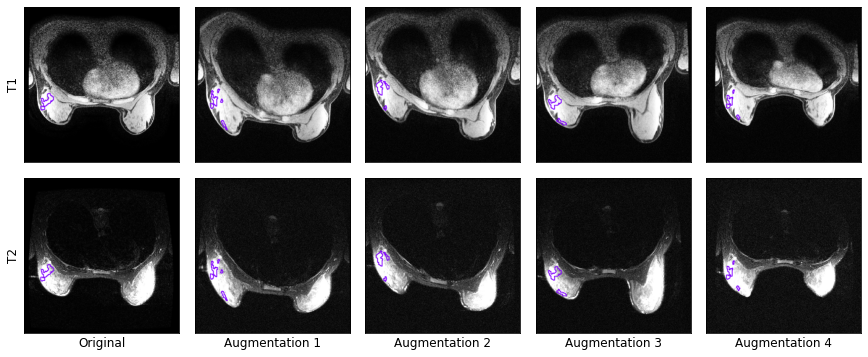

In [42]:
same_patient = "ACRIN-6698-102212"
# same_patient = "ACRIN-6698-103939"
# same_patient = None
original_directory = image_directory/"original_images"
# original_directory = None
fig = collate_augmentation_visualisations(image_directory/"fully_augmented_images", 5, same_patient, original_directory, image_directory/"full_augmentations")

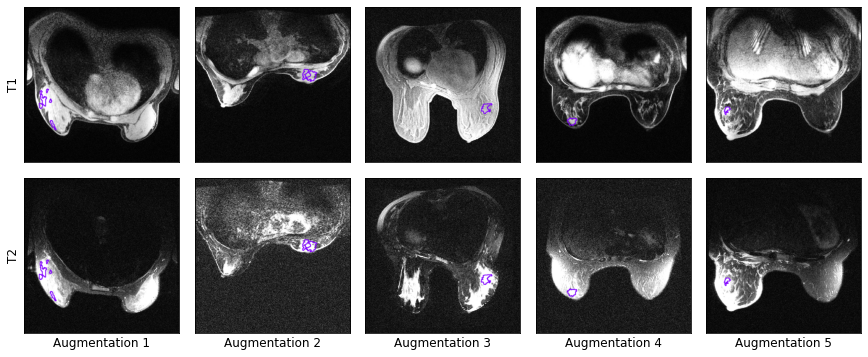

In [33]:
# same_patient = "ACRIN-6698-102212"
# same_patient = "ACRIN-6698-103939"
same_patient = None
# original_directory = image_directory
original_directory = None
fig = collate_augmentation_visualisations(image_directory/"fully_augmented_images", 5, same_patient, original_directory, image_directory/"multi_patient_full_augmentations")